<a href="https://colab.research.google.com/github/peteray-dev/Mental_Health_Modelling_Analysis/blob/master/Mental_Heath_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [2]:
!kaggle datasets download sumansharmadataworld/depression-surveydataset-for-analysis


Dataset URL: https://www.kaggle.com/datasets/sumansharmadataworld/depression-surveydataset-for-analysis
License(s): CC0-1.0
  0% 0.00/42.6k [00:00<?, ?B/s]
100% 42.6k/42.6k [00:00<00:00, 14.5MB/s]


In [3]:
!kaggle competitions download playground-series-s4e11

 88% 4.00M/4.55M [00:00<00:00, 41.8MB/s]
100% 4.55M/4.55M [00:00<00:00, 41.8MB/s]


In [4]:
! mkdir Original_depression_survey
! unzip /content/depression-surveydataset-for-analysis.zip -d Original_depression_survey

Archive:  /content/depression-surveydataset-for-analysis.zip
  inflating: Original_depression_survey/final_depression_dataset_1.csv  


In [5]:
! mkdir train_test_generated

! unzip /content/playground-series-s4e11.zip -d train_test_generated


Archive:  /content/playground-series-s4e11.zip
  inflating: train_test_generated/sample_submission.csv  
  inflating: train_test_generated/test.csv  
  inflating: train_test_generated/train.csv  


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [7]:
df_train = pd.read_csv('/content/train_test_generated/train.csv', index_col='id')
df_test = pd.read_csv('/content/train_test_generated/test.csv', index_col='id')
df_train.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,,,
0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [8]:
df_orig = pd.read_csv('/content/Original_depression_survey/final_depression_dataset_1.csv')
df_orig.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Pooja,Female,37,Ghaziabad,Working Professional,Teacher,NaN,2.0,NaN,NaN,4.0,7-8 hours,Moderate,MA,No,6,2,No,No
1,Reyansh,Male,60,Kalyan,Working Professional,Financial Analyst,NaN,4.0,NaN,NaN,3.0,5-6 hours,Unhealthy,B.Com,Yes,0,4,Yes,No
2,Manvi,Female,42,Bhopal,Working Professional,Teacher,NaN,2.0,NaN,NaN,3.0,5-6 hours,Moderate,M.Com,No,0,2,No,No
3,Isha,Female,44,Thane,Working Professional,Teacher,NaN,3.0,NaN,NaN,5.0,7-8 hours,Healthy,MD,Yes,1,2,Yes,No
4,Aarav,Male,48,Indore,Working Professional,UX/UI Designer,NaN,4.0,NaN,NaN,3.0,7-8 hours,Moderate,BE,Yes,6,5,Yes,No


In [9]:
display(df_train.info())
display(df_orig.info())

<class 'pandas.core.frame.DataFrame'>
Index: 140700 entries, 0 to 140699
Data columns (total 19 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Name                                   140700 non-null  object 
 1   Gender                                 140700 non-null  object 
 2   Age                                    140700 non-null  float64
 3   City                                   140700 non-null  object 
 4   Working Professional or Student        140700 non-null  object 
 5   Profession                             104070 non-null  object 
 6   Academic Pressure                      27897 non-null   float64
 7   Work Pressure                          112782 non-null  float64
 8   CGPA                                   27898 non-null   float64
 9   Study Satisfaction                     27897 non-null   float64
 10  Job Satisfaction                       112790 non-null  float

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Name                                   2556 non-null   object 
 1   Gender                                 2556 non-null   object 
 2   Age                                    2556 non-null   int64  
 3   City                                   2556 non-null   object 
 4   Working Professional or Student        2556 non-null   object 
 5   Profession                             1883 non-null   object 
 6   Academic Pressure                      502 non-null    float64
 7   Work Pressure                          2054 non-null   float64
 8   CGPA                                   502 non-null    float64
 9   Study Satisfaction                     502 non-null    float64
 10  Job Satisfaction                       2054 non-null   float64
 11  Slee

None

In [10]:
df_orig['Depression'] = df_orig['Depression'].map({'Yes': 1, 'No': 0})
df_orig.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Pooja,Female,37,Ghaziabad,Working Professional,Teacher,NaN,2.0,NaN,NaN,4.0,7-8 hours,Moderate,MA,No,6,2,No,0
1,Reyansh,Male,60,Kalyan,Working Professional,Financial Analyst,NaN,4.0,NaN,NaN,3.0,5-6 hours,Unhealthy,B.Com,Yes,0,4,Yes,0
2,Manvi,Female,42,Bhopal,Working Professional,Teacher,NaN,2.0,NaN,NaN,3.0,5-6 hours,Moderate,M.Com,No,0,2,No,0
3,Isha,Female,44,Thane,Working Professional,Teacher,NaN,3.0,NaN,NaN,5.0,7-8 hours,Healthy,MD,Yes,1,2,Yes,0
4,Aarav,Male,48,Indore,Working Professional,UX/UI Designer,NaN,4.0,NaN,NaN,3.0,7-8 hours,Moderate,BE,Yes,6,5,Yes,0


In [11]:
cat = df_train.select_dtypes(include='object')

for i in cat.columns:
  print(i, cat[i].nunique())

Name 422
Gender 2
City 98
Working Professional or Student 2
Profession 64
Sleep Duration 36
Dietary Habits 23
Degree 115
Have you ever had suicidal thoughts ? 2
Family History of Mental Illness 2


In [12]:
df_combined = pd.concat([df_train, df_orig], axis=0)
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143256 entries, 0 to 2555
Data columns (total 19 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Name                                   143256 non-null  object 
 1   Gender                                 143256 non-null  object 
 2   Age                                    143256 non-null  float64
 3   City                                   143256 non-null  object 
 4   Working Professional or Student        143256 non-null  object 
 5   Profession                             105953 non-null  object 
 6   Academic Pressure                      28399 non-null   float64
 7   Work Pressure                          114836 non-null  float64
 8   CGPA                                   28400 non-null   float64
 9   Study Satisfaction                     28399 non-null   float64
 10  Job Satisfaction                       114844 non-null  float64

In [13]:
y = df_combined['Depression']
X = df_combined.drop('Depression', axis=1)

In [14]:
for i in X[['Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction']].columns:
  print(i, X[i].value_counts())

Academic Pressure Academic Pressure
3.0    7588
5.0    6394
4.0    5250
1.0    4900
2.0    4267
Name: count, dtype: int64
Work Pressure Work Pressure
2.0    24786
4.0    22924
5.0    22860
3.0    22303
1.0    21963
Name: count, dtype: int64
CGPA CGPA
8.0400    829
9.9600    429
5.7400    415
8.9500    375
9.2100    347
         ... 
6.6400      1
7.0625      1
6.9800      1
6.4400      1
6.0900      1
Name: count, Length: 331, dtype: int64
Study Satisfaction Study Satisfaction
4.0    6476
2.0    5940
3.0    5926
1.0    5537
5.0    4520
Name: count, dtype: int64
Job Satisfaction Job Satisfaction
2.0    25214
5.0    23243
1.0    22720
3.0    22355
4.0    21312
Name: count, dtype: int64


In [15]:
imputer=SimpleImputer(strategy = 'constant')

In [16]:
cat_feat = X.select_dtypes(include='object').columns
num_feat = X.select_dtypes(exclude='object').columns

In [17]:
X[num_feat].isnull().sum()

,0
Age,0
Academic Pressure,114857
Work Pressure,28420
CGPA,114856
Study Satisfaction,114857
Job Satisfaction,28412
Work/Study Hours,0
Financial Stress,4


In [18]:
num1 =[]
num2 = []
for  i in num_feat:
  if X[i].isnull().sum() > 20000:
    num1.append(i)
  else:
    num2.append(i)

In [19]:
cat1 =[]
cat2 = []
for  i in cat_feat:
  if X[i].isnull().sum() > 20000:
    cat1.append(i)
  else:
    cat2.append(i)

In [20]:
print(num1)
print(num2)
print(cat1)
print(cat2)

['Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction']
['Age', 'Work/Study Hours', 'Financial Stress']
['Profession']
['Name', 'Gender', 'City', 'Working Professional or Student', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']


In [21]:
X[num1].isnull().sum()

,0
Academic Pressure,114857
Work Pressure,28420
CGPA,114856
Study Satisfaction,114857
Job Satisfaction,28412


In [22]:
imputer_const = SimpleImputer(strategy='constant')
imputer_mf = SimpleImputer(strategy='most_frequent')

num1_re = imputer_const.fit_transform(X[num1])
num1_re_test = imputer_const.transform(df_test[num1])
num2_re = imputer_mf.fit_transform(X[num2])
num2_re_test = imputer_mf.transform(df_test[num2])
cat1_re = imputer_const.fit_transform(X[cat1])
cat1_re_test = imputer_const.transform(df_test[cat1])
cat2_re = imputer_mf.fit_transform(X[cat2])
cat2_re_test = imputer_mf.transform(df_test[cat2])

In [23]:
df = pd.DataFrame(np.concatenate([ cat2_re, cat1_re, num1_re, num2_re ], axis=1), columns=cat2  + cat1 + num1 + num2, index=X.index )
test_df = pd.DataFrame(np.concatenate([ cat2_re_test, cat1_re_test, num1_re_test, num2_re_test ], axis=1), columns=cat2  + cat1 + num1 + num2, index=df_test.index )

In [24]:
df = pd.concat([df, y], axis=1)


In [25]:
# count = df['Degree'].value_counts()
# valid_degree = count[count > 5 ].index
# df = df[df['Degree'].isin(valid_degree)]

In [26]:
# DH = ['Moderate', 'Unhealthy', 'Healthy']

# df = df[df['Dietary Habits'].isin(DH)]

In [27]:
df['Work/Study Hours'].value_counts()

,count
Work/Study Hours,
10.0,14417
11.0,13037
9.0,12921
0.0,12270
12.0,11600
2.0,10801
6.0,10627
7.0,10058
1.0,9993


In [28]:
df[num_feat] = df[num_feat].astype(float)
test_df[num_feat] = test_df[num_feat].astype(float)

# df['Depression'] = df['Depression'].astype(int)

In [29]:
X = df.drop('Depression', axis=1)
y = df['Depression']

In [30]:
X_train, X_val, y_train, y_val = train_test_split(df, y, test_size=0.2, random_state=42, stratify=y)

In [31]:
ohe_feat = []
non_ohe_feat = []
for i in cat_feat:
  if df[i].nunique() < 10:
    ohe_feat.append(i)
  else:
    non_ohe_feat.append(i)

In [32]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary')

In [36]:
def ohe(X_train, ohe_feat, num_feat, non_ohe_feat):
  ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary')
  ohe_res = ohe.fit_transform(X_train[ohe_feat])
  ohe_train_df = pd.DataFrame(ohe_res, columns=ohe.get_feature_names_out())

  res_train = pd.concat([X_train[non_ohe_feat], X_train[num_feat]], axis=1)
  res_train.reset_index(inplace=True, drop=True)
  train_df = pd.concat([res_train, ohe_train_df], axis=1)

  return train_df

In [37]:
X_train_df = ohe(X_train, ohe_feat, num_feat, non_ohe_feat)
X_val_df = ohe(X_val, ohe_feat, num_feat, non_ohe_feat)
test_df_new = ohe(test_df, ohe_feat, num_feat, non_ohe_feat)


In [38]:
# test_df_new.info()

In [39]:
# X_train_df.info()

In [40]:

# num_feat =num_feat.astype('category')
def types(X, cat):
  for i in cat:
    X[i] = X[i].astype('category')
  return X

In [41]:
X_train_df = types(X_train_df, non_ohe_feat)
X_val_df = types(X_val_df, non_ohe_feat)
test_df_new = types(test_df_new, non_ohe_feat)

XGBOOST Model

In [42]:
xgbc = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, enable_categorical=True)
xgbc.fit(X_train_df, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [43]:
print(xgbc.score(X_train_df, y_train))
print(xgbc.score(X_val_df, y_val))

0.9992495898921504
0.9126064498115315


In [44]:
xgbc_pred = xgbc.predict(X_val_df)

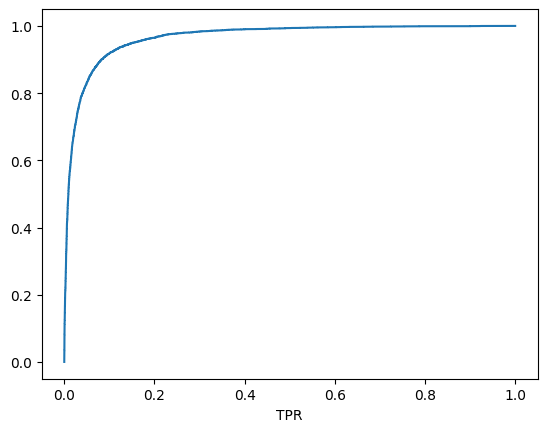

In [45]:
roc_pos = roc_curve(y_val, xgbc.predict_proba(X_val_df)[:, 1])
plt.plot(roc_pos[0], roc_pos[1])
plt.xlabel('False Positive Rate')
plt.xlabel('TPR')
plt.show()

In [46]:
y_pred = xgbc.predict(X_val_df)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     23447
           1       0.91      0.58      0.71      5205

    accuracy                           0.91     28652
   macro avg       0.91      0.78      0.83     28652
weighted avg       0.91      0.91      0.90     28652



In [47]:
xgbc_test_pred = xgbc.predict(test_df_new)

In [50]:
submission = pd.DataFrame({

    'id': test_df.index,  # 'id' column from test data

    'Depression': xgbc_test_pred.astype(int)  # Predicted labels for depression

})

# Save the submission file as a CSV

submission.to_csv('submission.csv', index=False)

print("Submission file saved as 'submission.csv'")

Submission file saved as 'submission.csv'


Fine tunning

In [ ]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
params = {
    'n_estimators': [500, 1000],
    'booster': ['gbtree', 'dart'],
    # 'objective': ['binary:logistic'],
    'eta': [0.01, 0.1],
    # 'min_child_weight': [1, 5],
    # 'gamma': [0.5, 1],
    'subsample': [0.5, 1.0],
    # 'colsample_bytree': [0.5, 1.0],
    'max_depth': [3, 5]
}

clf = GridSearchCV(XGBClassifier(enable_categorical=True), params, scoring='roc_auc', cv=stratified_kfold, n_jobs=-1)
clf.fit(X_train_df, y_train)

In [ ]:
grid_cv_result = pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score')
grid_cv_result[['params','mean_train_score', 'mean_test_score', 'rank_test_score']]

In [ ]:
print(f'the best parameter: {clf.best_params_}')
print(f'the best score: {clf.best_score_}')